
**<font size=3>导入平台数据集</font>**

**数据集插件 -> 添加数据集 -> 数据集列表 -> 插入代码**

导入平台数据集并调试好代码后，点击代码编辑区的【运行全量】按钮，查看在全量数据的运行结果，全量数据运行结果的调用方式可参考：[《用户手册-全量运行代码调用》](/#/user-manual/experiment/experiment-debug)

全量运行之后，获取全量运行结果的主要流程：
**上传模型文件 -> 申报审核文件 -> 审核通过 ->下载文件**

上传模型文件接口示例：

```python
import wfio
wfio.upload_to_oss(server_path,local_path) 
#server_path是上传到服务器的文件名称，可以自定义
#local_path是本地上传的文件路径, 必须是本地已经存在的文件路径。
```


In [1]:
!pip install torch

In [2]:
!pip install torchvision

In [3]:
#从S3将训练数据集下载到当前目录下的"./traindata"文件夹下

import wfio
_INPUT1 = '{"type":25,"uri":"awss33ead09ff7f3b4555808852ce782a8afc:/"}'   #文件的路径
marker = ""
while True:
    ret = wfio.listdir(_INPUT1, marker=marker)
    print("Downloading {0} files...".format(len(ret["file_list"])))
    wfio.download(
        _INPUT1,
        local_path="traindata",                 # 文件下载保存的目录，为None则表示下载到当前目录
        selected_files=ret["file_list"], # 下载的文件名称列表，至少指定一个文件名称
        overwrite=False                  # 是否覆盖同名文件
    )
    if not ret["has_more"]:              # 判断是否有更多文件
        print("All files download completed")
        break
    marker = ret["next_marker"]          # 下一次分页查询的开始标识

All files download completed


In [4]:
#从S3将测试数据集下载到当前目录下的"./testdata"文件夹下

import wfio
_INPUT2 = '{"type":25,"uri":"awss393cee53c4066485bab9fa721272e90df:/"}'   #文件的路径
marker = ""
while True:
    ret = wfio.listdir(_INPUT2, marker=marker)
    print("Downloading {0} files...".format(len(ret["file_list"])))
    wfio.download(
        _INPUT2,
        local_path="testdata",                 # 文件下载保存的目录，为None则表示下载到当前目录
        selected_files=ret["file_list"], # 下载的文件名称列表，至少指定一个文件名称
        overwrite=False                  # 是否覆盖同名文件
    )
    if not ret["has_more"]:              # 判断是否有更多文件
        print("All files download completed")
        break
    marker = ret["next_marker"]          # 下一次分页查询的开始标识

All files download completed


In [5]:
#导入必要的包
import os
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from wf_analyse.analyse import base
import numpy as np

In [6]:
#定义数据集
class Corel5kDataset(Dataset):
    def __init__(self, label_dic, root_path, transform=None, target_transform=None):
        imgs_path = []
        imgs_label = []
        for root,dir_list,file_list in os.walk(root_path):  
            for file_name in file_list: 
                #print(os.path.join(root, file_name))
                img_path = os.path.join(root, file_name)
                imgs_path.append(img_path)
                imgs_label.append(label_dic[root.split("/")[-1]])

        self.imgs_path = imgs_path
        self.imgs_label = imgs_label
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        return len(self.imgs_label)
 
    def __getitem__(self, idx):
        image = Image.open(self.imgs_path[idx])
        label = self.imgs_label[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

In [7]:
#自定义简单CNN，输入是224*224
class Net(nn.Module):
    def __init__(self, classes_num = 4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128,3,3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 16,3, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, classes_num)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
def train_model(model, criterion, optimizer,  dataloaders,dataset_sizes,num_epochs=100):
    best_loss = 100
    best_acc = 0
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    
    print("\nStart Train......")
    #创建模型保存的文件夹
    if not  os.path.exists("./models"):
        os.makedirs("./models")
        
    for epoch in range(num_epochs):
        start = time.time()
        print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            for i, data in enumerate(dataloaders[phase], 0):
                batch_img, batch_labels = data['image'], data['label']
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(batch_img)
                    preds = torch.argmax(outputs, dim=1)
                    loss = criterion(outputs, batch_labels)
                    
                    #训练模式进行反向传播，更新参数
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * batch_img.size(0)
                running_corrects += torch.sum(preds.float() == batch_labels.float())
            end = time.time()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #保存acc最佳的模型
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model, './models/mycnn.pth')
            
            if phase == 'test' and epoch_loss < best_loss:
                best_loss = epoch_loss
            
            #保存训练过程loss与acc值
            if phase == "train":
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                test_loss_list.append(epoch_loss)
                test_acc_list.append(epoch_acc)
            
        
        
        print('Training complete in {:.4f} mins'.format((end - start)/60))
        print('Best val Loss: {:4f}\n'.format(best_loss))
        print('Best val acc: {:4f}\n'.format(best_acc))
    
    
    print("End Train......\n")
    
    #在全量运行时，保存训练集在训练过程中的loss和acc值，用于绘制loss和acc变化曲线图
    for i in range(0, num_epochs, 1):
        base.save_norm_by_step(model_name='train', norm_name='Loss',norm_value=np.float(train_loss_list[i]),step=i)
        base.save_norm_by_step(model_name='train', norm_name='Accuracy',norm_value=np.float(train_acc_list[i]),step=i)
    
     #在全量运行时，保存测试集在训练过程中的loss与acc值，用于绘制loss和acc变化曲线图
    for i in range(0, num_epochs, 1):
        base.save_norm_by_step(model_name='test', norm_name='Loss',norm_value=np.float(test_loss_list[i]),step=i)
        base.save_norm_by_step(model_name='test', norm_name='Accuracy',norm_value=np.float(test_acc_list[i]),step=i)
        
    #绘制验证集在训练过程中的loss曲线图
    epoch = []  # 横坐标,迭代次数
    for i in range(0, num_epochs, 1):
        epoch.append(i)

    plt.plot(epoch, train_loss_list)
    # plt.plot([1,3,3,4], [1,4,9,16])
    plt.ylabel('train loss')
    plt.xlabel('train epoch')
    plt.title(" Curve of loss(crossentory) function of train set")
    plt.show()
    
    #绘制验证集在训练过程中的acc曲线图
    epoch = []  # 横坐标,迭代次数
    for i in range(0, num_epochs, 1):
        epoch.append(i)

    plt.plot(epoch, train_acc_list)
    # plt.plot([1,3,3,4], [1,4,9,16])
    plt.ylabel('train acc')
    plt.xlabel('train epoch')
    plt.title(" Curve of Accuracy  function of train set")
    plt.show()

In [9]:
def main():
    #1.基本参数设置
    learning_rate = 0.01  #学习率
    epoch_num = 5         #学习迭代次数
    
    
    #2.数据位置
    train_root_path = './traindata/image_train/'
    test_root_path = './testdata/image_test/'
    
    #3.类别与类别的字典表
    label_dic = {"flower":0, "plane":1, "starfish":2, "sun":3}
    
    #4.数据预处理
    train_transform =transforms.Compose(
        [transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Resize([224,224]),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     
    test_transform =transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize([224,224]),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    #5.生成dataloader数据集
    train_set = Corel5kDataset(label_dic=label_dic, root_path=train_root_path,transform=train_transform)
    train_loader = DataLoader(train_set, batch_size=3, shuffle=True)
    
    test_set = Corel5kDataset(label_dic=label_dic, root_path=test_root_path,transform=test_transform)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
    
    dataloaders = {'train': train_loader, 'test': test_loader}
    dataset_sizes = {'train': len(train_set), 'test': len(test_set)}
    print('train samples:{}张'.format(dataset_sizes["train"]))
    print('test samples:{}张'.format(dataset_sizes["test"]))
    
    
    
    #6。定义模型、优化器、损失函数
    model = Net()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    #7.开始训练模型
    train_model(model, criterion, optimizer, num_epochs=epoch_num, dataloaders=dataloaders, dataset_sizes=dataset_sizes )

train samples:200张
test samples:36张

Start Train......

Epoch: 1/5
----------
train Loss: 1.3220 Acc: 0.4000
test Loss: 1.4628 Acc: 0.4444
Training complete in 0.0605 mins
Best val Loss: 1.462825

Best val acc: 0.444444


Epoch: 2/5
----------
train Loss: 1.3503 Acc: 0.2900
test Loss: 1.3624 Acc: 0.3056
Training complete in 0.0471 mins
Best val Loss: 1.362354

Best val acc: 0.444444


Epoch: 3/5
----------
train Loss: 1.2698 Acc: 0.4850
test Loss: 1.1300 Acc: 0.4722
Training complete in 0.0738 mins
Best val Loss: 1.129962

Best val acc: 0.472222


Epoch: 4/5
----------
train Loss: 1.2755 Acc: 0.4000
test Loss: 0.9908 Acc: 0.6111
Training complete in 0.0495 mins
Best val Loss: 0.990757

Best val acc: 0.611111


Epoch: 5/5
----------
train Loss: 1.1481 Acc: 0.4550
test Loss: 0.9456 Acc: 0.5278
Training complete in 0.0647 mins
Best val Loss: 0.945568

Best val acc: 0.611111

End Train......

saving 【train】【step:0】 Loss : 1.3219946891069412
saving 【train】【step:0】 Accuracy : 0.4
saving 【tra

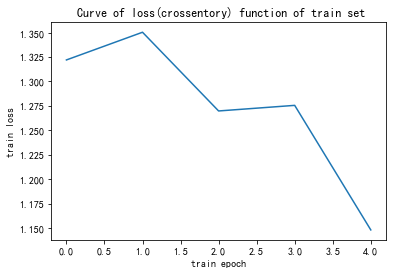

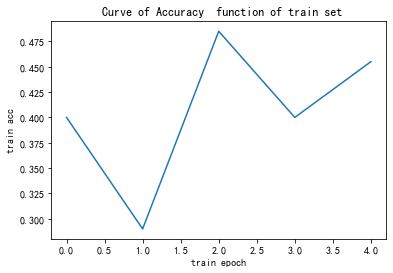

当前环境 [调试环境] 禁止上传到oss 文件系统 


In [10]:
if __name__ == '__main__':
    #训练
    main()
    #模型申报审核
    wfio.upload_to_oss("mycnn.pth", "./models/mycnn.pth")  #将分类模型上传至 oss     